In [18]:
import json
import pandas as pd
import os
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import statistics
from sklearn.linear_model import LinearRegression


ta_root_dir = 'tennis_abstract'
ta_df_dir = 'tennis_abstract_dfs'
matchhead_verbose = ["date","tourn","surf","level","win/loss","rank","seed","entry","round",
                 "score","max_num_of_sets","opp","orank","oseed","oentry","ohand","obday",
                 "oheight","ocountry","oactive","time_minutes","aces","dfs","service_pts","first_serves_in","first_serves_won",
                 "second_serves_won",'service_games',"break_points_saved","break_points_faced","oaces","odfs","oservice_pts","ofirst_serves_in","ofirst_serves_won",
                 "osecond_serves_won",'oservice_games',"obreak_points_saved","obreak_points_faced", "obackhand", "chartlink",
                 "pslink","whserver","matchid","wh","roundnum","matchnum", "oforeign_key"]

round_vals = {
    'F': 1,
    'SF': 2,
    'QF': 3,
    'R16': 4,
    'R32': 5,
    'R64': 6,
    'R128': 7,
    'Q3': 8,
    'Q2': 9,
    'Q1': 10
}
round_vals = defaultdict(lambda: 11, round_vals)
prev_match_stats = ['prev_10_mean_serve_win_rate','prev_10_median_serve_win_rate','prev_10_mean_return_win_rate','prev_10_median_return_win_rate','prev_10_mean_first_serve_in_rate','prev_10_median_first_serve_in_rate','prev_10_mean_first_return_in_rate','prev_10_median_first_return_in_rate','prev_10_mean_first_return_win_rate','prev_10_median_first_return_win_rate','prev_10_mean_overall_win_rate','prev_10_median_overall_win_rate']
o_prev_match_stats = [f'o{n}' for n in prev_match_stats]


In [19]:
def gen_df(name):
    html_path = f'{ta_root_dir}/{name}.html'
    assert os.path.exists(html_path)
    with open(html_path, 'r') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, "html.parser")
    script_tags = soup.find_all("script")
    matchmx = None
    for script in script_tags:
        if script.string:  # Ensure the script tag contains JavaScript code
            match = re.search(r'var\s+matchmx\s*=\s*(\[.*?\]);', script.string, re.DOTALL)
            if match:
                # Extract the JavaScript array or object
                ochoices_str = match.group(1)
                # Convert the JavaScript array/object to a Python object
                matchmx = eval(ochoices_str)
    assert matchmx is not None
    if len(matchmx[0])== 47:
        matchmx = [m+[''] for m in matchmx]
    try:
        match_df = pd.DataFrame(matchmx, columns=matchhead_verbose)
    except Exception as e:
        breakpoint()
    return match_df

In [20]:

def calc_serve_win_rate(row):
    elems = ['first_serves_won', 'second_serves_won', 'service_pts']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['service_pts'])
    if denom == 0:
        return 0
    return (float(row['first_serves_won']) + float(row['second_serves_won'])) / denom

def calc_overall_win_rate(row):
    elems = ['first_serves_won', 'second_serves_won', 'ofirst_serves_won', 'osecond_serves_won', 'service_pts', 'oservice_pts']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['service_pts'] + row['oservice_pts'])
    if denom == 0:
        return 0
    return (float(row['first_serves_won']) + float(row['second_serves_won']) + (float(row['oservice_pts']) - float(row['first_serves_won']) - float(row['second_serves_won'])) ) / denom

def calc_return_win_rate(row):
    elems = ['ofirst_serves_won', 'osecond_serves_won', 'oservice_pts']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['oservice_pts'])
    if denom == 0:
        return 0
    return 1 - ((float(row['ofirst_serves_won']) + float(row['osecond_serves_won'])) / denom)

def calc_first_serve_win_rate(row):
    elems = ['first_serves_won', 'first_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['first_serves_in'])
    if denom == 0:
        return 0
    return float(row['first_serves_won']) / denom

def calc_first_serve_in_rate(row):
    elems = ['service_pts', 'first_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['service_pts'])
    if denom == 0:
        return 0
    return float(row['first_serves_in']) / denom

def calc_first_return_in_rate(row):
    elems = ['oservice_pts', 'ofirst_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['oservice_pts'])
    if denom == 0:
        return 0
    return float(row['ofirst_serves_in']) / denom

def calc_second_serve_win_rate(row):
    elems = ['second_serves_won', 'service_pts', 'first_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = (float(row['service_pts']) - float(row['first_serves_in']))
    if denom == 0:
        return 0
    return float(row['second_serves_won']) / denom
def calc_first_return_win_rate(row):
    elems = ['ofirst_serves_won', 'ofirst_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['ofirst_serves_in'])
    if denom == 0:
        return 0
    return 1 - (float(row['ofirst_serves_won']) / denom)

def calc_second_return_win_rate(row):
    elems = ['osecond_serves_won', 'oservice_pts', 'ofirst_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = (float(row['oservice_pts']) - float(row['ofirst_serves_in']))
    if denom == 0:
        return 0
    return 1-(float(row['osecond_serves_won']) / denom)

In [21]:
def edit_df(name):
    match_df = pd.read_pickle(f'{ta_df_dir}/{name}.pkl')
    match_df['formatted_opp'] = match_df['opp'].apply(lambda name: name.replace(' ', ''))
    match_df['round_val'] = match_df['round'].apply(lambda rd: round_vals[rd])
    match_df['serve_win_rate'] = match_df.apply(calc_serve_win_rate, axis=1)
    match_df['overall_win_rate'] = match_df.apply(calc_overall_win_rate, axis=1)
    match_df['return_win_rate'] = match_df.apply(calc_return_win_rate, axis=1)
    match_df['first_serve_in_rate'] = match_df.apply(calc_first_serve_in_rate, axis=1)
    match_df['first_return_in_rate'] = match_df.apply(calc_first_return_in_rate, axis=1)
    match_df['first_serve_win_rate'] = match_df.apply(calc_first_serve_win_rate, axis=1)
    match_df['second_serve_win_rate'] = match_df.apply(calc_second_serve_win_rate, axis=1)
    match_df['first_return_win_rate'] = match_df.apply(calc_first_return_win_rate, axis=1)
    match_df['second_return_win_rate'] = match_df.apply(calc_second_return_win_rate, axis=1)

    rows_to_go = match_df[match_df['serve_win_rate'].isna() | match_df['score'].str.contains('RET') | ~match_df['win/loss'].isin(['W', 'L']) ]
    # assert len(rows_to_go) < 0.15 * len(match_df)
    match_df.drop(rows_to_go.index, inplace=True)
    match_df.sort_index(ascending=False, inplace=True)
    window_size = 10
    match_df['prev_10_mean_serve_win_rate'] = match_df['serve_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_serve_win_rate'] = match_df['serve_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_return_win_rate'] = match_df['return_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_return_win_rate'] = match_df['return_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_first_serve_win_rate'] = match_df['first_serve_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_first_serve_win_rate'] = match_df['first_serve_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_first_serve_in_rate'] = match_df['first_serve_in_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_first_serve_in_rate'] = match_df['first_serve_in_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_first_return_in_rate'] = match_df['first_return_in_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_first_return_in_rate'] = match_df['first_return_in_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_first_return_win_rate'] = match_df['first_return_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_first_return_win_rate'] = match_df['first_return_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_overall_win_rate'] = match_df['overall_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_overall_win_rate'] = match_df['overall_win_rate'].rolling(window=window_size, closed='left').median()
    match_df = pd.concat([match_df, rows_to_go])
    match_df.sort_index(ascending=False, inplace=True)
    pd.to_pickle(match_df, f'{ta_df_dir}/{name}.pkl')

In [22]:
name = 'HugoDellien'
hugodellien_df = pd.read_pickle(f'{ta_df_dir}/{name}.pkl')

In [23]:
name = 'CarlosAlcaraz'
alcaraz_html_path = f'{ta_root_dir}/{name}.html'
with open(alcaraz_html_path, 'r') as file:
    html_content = file.read()
soup = BeautifulSoup(html_content, "html.parser")
script_tags = soup.find_all("script")
ochoices = None
for script in script_tags:
    if script.string:  # Ensure the script tag contains JavaScript code
        match = re.search(r'var\s+ochoices\s*=\s*(\[.*?\]);', script.string, re.DOTALL)
        if match:
            # Extract the JavaScript array or object
            ochoices_str = match.group(1)
            # Convert the JavaScript array/object to a Python object
            ochoices = eval(ochoices_str)
ta_names = [v.replace(' ', '') for v in ochoices]
edit_df(name)
for name in tqdm(ta_names):
    edit_df(name)

# match_df.loc[match_df['serve_win_rate'] < 0.3, 'score']

100%|██████████| 185/185 [00:12<00:00, 15.11it/s]


In [24]:
def set_opposition_prev_match_stats(match):
    name = 'CarlosAlcaraz'
    opp_df = pd.read_pickle(f'{ta_df_dir}/{match["formatted_opp"]}.pkl')
    opp_match_stats = opp_df.loc[(opp_df['date'] == match['date']) & (opp_df['formatted_opp'] == name), prev_match_stats]
    assert opp_match_stats.shape[0] <= 1
    if opp_match_stats.shape[0] == 1:
        opp_match_stats = opp_match_stats.iloc[0]
        if len(opp_match_stats) == len(prev_match_stats):
            return opp_match_stats
    return [np.nan for _ in range(len(prev_match_stats))]

In [25]:
name = 'CarlosAlcaraz'
match_df = pd.read_pickle(f'{ta_df_dir}/{name}.pkl')
window_size = 10
match_df[o_prev_match_stats] = np.nan
match_df[o_prev_match_stats] = match_df.apply(set_opposition_prev_match_stats,axis=1)

# return match[['date', 'tourn', 'formatted_opp']]
# name2 = 'CasperRuud'
# match_df2 = pd.read_pickle(f'{ta_df_dir}/{name2}.pkl')


# plt.plot(real_vals, color='b')
# plt.plot(predicted_vals, color='r')
# plt.show()

In [26]:
matches_with_oprev_values = match_df.dropna(subset=o_prev_match_stats+prev_match_stats)
model = LinearRegression()
X = matches_with_oprev_values[['prev_10_mean_serve_win_rate', 'oprev_10_mean_return_win_rate']]
y = matches_with_oprev_values['serve_win_rate']
model.fit(X, y)
(c_serve, c_oreturn), i = model.coef_, model.intercept_
match_df['LR_serve_win_rate_pred'] = match_df.loc[matches_with_oprev_values.index].apply(lambda row: c_serve*row['prev_10_mean_serve_win_rate']+c_oreturn*row['oprev_10_mean_return_win_rate']+i, axis=1)
(round(c_serve,2), round(c_oreturn,2)), round(i, 2)

((0.44, -0.49), 0.56)

In [27]:
X_cols = ['prev_10_mean_first_serve_win_rate','prev_10_mean_first_serve_in_rate','oprev_10_mean_first_return_win_rate','oprev_10_mean_first_return_in_rate']
matches_with_oprev_values = match_df.dropna(subset=o_prev_match_stats+prev_match_stats)
model2 = LinearRegression()
X = matches_with_oprev_values[X_cols]
y = matches_with_oprev_values['serve_win_rate']
model2.fit(X, y)
(c_fserve_w, c_fserve_i, c_ofreturn_w, c_ofreturn_i), i = model2.coef_, model2.intercept_
match_df['LR_serve_win_rate_pred_2'] = match_df.loc[matches_with_oprev_values.index].apply(lambda row: np.dot(row[X_cols],model2.coef_)+i, axis=1)
LR_2_vals = [round(c,2) for c in model2.coef_ + [model2.intercept_]]

In [28]:
X_cols = ['prev_10_mean_overall_win_rate', 'oprev_10_mean_overall_win_rate', 'prev_10_mean_serve_win_rate', 'oprev_10_mean_return_win_rate']
matches_with_oprev_values = match_df.dropna(subset=o_prev_match_stats+prev_match_stats)
model3 = LinearRegression()
X = matches_with_oprev_values[X_cols]
y = matches_with_oprev_values['serve_win_rate']
model3.fit(X, y)
i = model3.intercept_
match_df['LR_serve_win_rate_pred_3'] = match_df.loc[matches_with_oprev_values.index].apply(lambda row: np.dot(row[X_cols],model3.coef_)+i, axis=1)
[round(c,2) for c in model3.coef_], round(i, 2)

([-0.4, 1.49, 0.45, -0.51], 0.55)

In [29]:
# model2 = LinearRegression()
# X = matches_with_oprev_values[['prev_10_mean_serve_win_rate', 'oprev_10_mean_return_win_rate']]
# mean_prev_10_mean_serve_win_rate = X['prev_10_mean_serve_win_rate'].mean()
# mean_oprev_10_mean_return_win_rate = X['oprev_10_mean_return_win_rate'].mean()
# match_df['baselined_prev_10_mean_serve_win_rate'] = match_df.loc[matches_with_oprev_values.index, 'prev_10_mean_serve_win_rate'] - mean_prev_10_mean_serve_win_rate
# match_df['baselined_oprev_10_mean_return_win_rate'] = match_df.loc[matches_with_oprev_values.index, 'oprev_10_mean_return_win_rate'] - mean_oprev_10_mean_return_win_rate
# matches_with_oprev_values = match_df.dropna(subset=o_prev_match_stats+prev_match_stats)
# X = matches_with_oprev_values[['baselined_prev_10_mean_serve_win_rate', 'baselined_oprev_10_mean_return_win_rate']]
# y = matches_with_oprev_values['serve_win_rate']
# model2.fit(X, y)
# (c_serve, c_oreturn), i = model2.coef_, model2.intercept_
# match_df['LR_serve_win_rate_pred'] = match_df.loc[matches_with_oprev_values.index].apply(lambda row: c_serve*row['baselined_prev_10_mean_serve_win_rate']+c_oreturn*row['baselined_oprev_10_mean_return_win_rate']+i, axis=1)
# (round(c_serve,2), round(c_oreturn,2)), round(i, 2)

In [30]:
matches_with_LR_pred = match_df.dropna(subset=['LR_serve_win_rate_pred'])
real_vals = list(matches_with_LR_pred['serve_win_rate'])
num_of_vals = len(real_vals)
correct_threshold = 0.01
predicted_vals_mean = matches_with_LR_pred['prev_10_mean_serve_win_rate']
predicted_vals_median = matches_with_LR_pred['prev_10_median_serve_win_rate']
predicted_vals_LR = matches_with_LR_pred['LR_serve_win_rate_pred']
predicted_vals_LR_2 = matches_with_LR_pred['LR_serve_win_rate_pred_2']
predicted_vals_LR_3 = matches_with_LR_pred['LR_serve_win_rate_pred_3']
print(f'mean SD: {statistics.stdev(np.abs(np.subtract(real_vals, predicted_vals_mean)))}')
print(f'median SD: {statistics.stdev(np.abs(np.subtract(real_vals, predicted_vals_median)))}')
print(f'LR SD: {statistics.stdev(np.abs(np.subtract(real_vals, predicted_vals_LR)))}')
print(f'LR_2 SD: {statistics.stdev(np.abs(np.subtract(real_vals, predicted_vals_LR_2)))}')
print(f'LR_3 SD: {statistics.stdev(np.abs(np.subtract(real_vals, predicted_vals_LR_3)))}')
print()
print(f'mean MAE: {np.abs(np.subtract(real_vals, predicted_vals_mean)).mean()}')
print(f'median MAE: {np.abs(np.subtract(real_vals, predicted_vals_median)).mean()}')
print(f'LR MAE: {np.abs(np.subtract(real_vals, predicted_vals_LR)).mean()}')
print(f'LR_2 MAE: {np.abs(np.subtract(real_vals, predicted_vals_LR_2)).mean()}')
print(f'LR_3 MAE: {np.abs(np.subtract(real_vals, predicted_vals_LR_3)).mean()}')
print()
print(f'mean correct rate: {float(len([p for p,r in zip(real_vals, predicted_vals_mean) if abs(p-r)/r < correct_threshold])) / num_of_vals}')
print(f'median correct rate: {float(len([p for p,r in zip(real_vals, predicted_vals_median) if abs(p-r)/r < correct_threshold])) / num_of_vals}')
print(f'LR correct rate: {float(len([p for p,r in zip(real_vals, predicted_vals_LR) if abs(p-r)/r < correct_threshold])) / num_of_vals}')
print(f'LR_2 correct rate: {float(len([p for p,r in zip(real_vals, predicted_vals_LR_2) if abs(p-r)/r < correct_threshold])) / num_of_vals}')
print(f'LR_3 correct rate: {float(len([p for p,r in zip(real_vals, predicted_vals_LR_3) if abs(p-r)/r < correct_threshold])) / num_of_vals}')
# print()

mean SD: 0.048554749414693586
median SD: 0.047792144632741604
LR SD: 0.045238220304446575
LR_2 SD: 0.044541357024126524
LR_3 SD: 0.045008179211451727

mean MAE: 0.06080428077647557
median MAE: 0.06125668059257285
LR MAE: 0.05812342737564371
LR_2 MAE: 0.05786954882833639
LR_3 MAE: 0.058264491620476776

mean correct rate: 0.08143322475570032
median correct rate: 0.06514657980456026
LR correct rate: 0.05863192182410423
LR_2 correct rate: 0.07166123778501629
LR_3 correct rate: 0.06514657980456026


In [31]:
relevant_cols = ['opp', 'serve_win_rate', 'LR_serve_win_rate_pred'] + ['prev_10_mean_first_serve_win_rate','prev_10_mean_first_serve_in_rate','oprev_10_mean_first_return_win_rate','oprev_10_mean_first_return_in_rate']
relevant_df = match_df[relevant_cols]
relevant_df = relevant_df.dropna(subset=['LR_serve_win_rate_pred'])

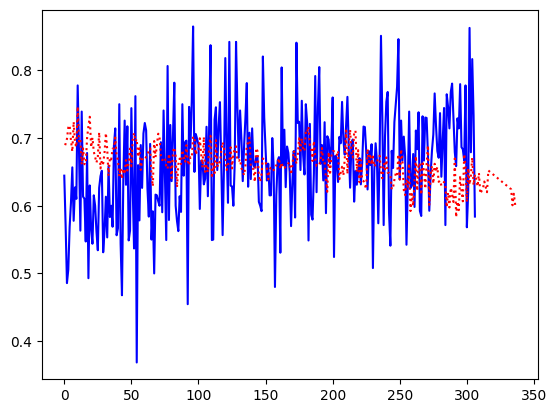

In [32]:
plt.plot(real_vals, color='b')
plt.plot(predicted_vals_LR, ':', color='r' )
plt.show()